## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device name: ", device)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

device name:  cuda:0


## Load Data (Cifar 10)

In [2]:
model_tag = input("Enter model tag: ")
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
run_name = model_tag + '_' + dt_string
os.mkdir("./runs/" + run_name)

# initialize summary writer for Tensorboard
writer = SummaryWriter('./runs/' + run_name)

data_path = "/data2/users/lr4617/data/"
download_bool = False
batch_size = 64

if len(os.listdir(data_path)) == 0:
    download_bool = True

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=download_bool, transform=transform_data)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=download_bool, transform=transform_data)

train_loader = DataLoader(cifar10_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size = batch_size, shuffle=False)
# it is important NOT to shuffle the test dataset since the adversarial variation 
# delta are going to be saved in memory in the same order as the test samples are. 

# classes label for Cifar 10 dataset (just for display)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Visualize Dataset

### Helper Function

In [3]:
def imshow_(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5    # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        # plt.imshow(np.transpose((npimg* 255).astype(np.uint8), (1, 2, 0)))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

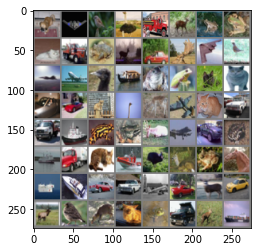

In [4]:
# dislay batch images
data_iter = iter(train_loader)
samples, labels = data_iter.next()

img = tv.utils.make_grid(samples)
imshow_(img)

## Models

In [5]:
## Simple CNN model (Standard Pytorch)
class CNN_1(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.device = device

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x).to(device)

        return x

## 2 layer CNN Model
class CNN_2(nn.Module):
    def __init__(self, device):

        super().__init__()
        self.device = device
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(1600, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x).to(device)
        return x

## 3-layer CNN model
class CNN_3(nn.Module):
    def __init__(self, device):

        super().__init__()
        self.device = device
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x).to(device)
        return x

## model selection
net = CNN_1(device)

### Tensorboard Test

<class 'torch.Tensor'>


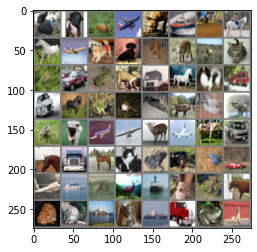

In [22]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = tv.utils.make_grid(images)

# show images
imshow_(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('Batch Example', img_grid)
writer.add_graph(net, images)
writer.close()

## Utils

In [6]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(28*8, 28*8))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
        imshow_(images.cpu()[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"), fontsize=84)
    return fig

In [8]:
def train (loader, model, n_epochs=30):
    opt = optim.SGD(model.parameters(), lr=1e-1)

    for epoch_num in range(n_epochs):
        total_loss, total_err = 0.,0.
        for i, data in enumerate(loader, 0):
            X,y = data
            X,y = X.to(device), y.to(device)
            yp = model(X)
            loss = nn.CrossEntropyLoss()(yp,y)
            if opt:
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            total_err += (yp.max(dim=1)[1] != y).sum().item()
            total_loss += loss.item()
            
        print(*("{:.6f}".format(i) for i in (int(epoch_num), total_err/len(loader.dataset), total_loss/len(loader.dataset))), sep="\t")   
      
        # ...log the running loss
        writer.add_scalar('training loss',
                        total_err/len(loader.dataset),
                        epoch_num* len(loader) + i)
        writer.add_scalar('training error',
                        total_loss/len(loader.dataset),
                        epoch_num* len(loader) + i)
        

## Train Model

In [9]:
train(train_loader, net.cuda())

/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.000000	0.665780	0.028124
1.000000	0.512700	0.022368
2.000000	0.454500	0.019977
3.000000	0.415700	0.018340
4.000000	0.389380	0.017145
5.000000	0.361280	0.016047
6.000000	0.345600	0.015187
7.000000	0.323180	0.014344
8.000000	0.309140	0.013690
9.000000	0.299540	0.013128
10.000000	0.288420	0.012624
11.000000	0.277960	0.012253
12.000000	0.267340	0.011721
13.000000	0.257440	0.011239
14.000000	0.250720	0.010981
15.000000	0.243980	0.010668
16.000000	0.234180	0.010268
17.000000	0.228540	0.009916
18.000000	0.225060	0.009753
19.000000	0.221780	0.009608
20.000000	0.211980	0.009296
21.000000	0.209840	0.009111
22.000000	0.204620	0.008911
23.000000	0.203860	0.008863
24.000000	0.195260	0.008483
25.000000	0.193680	0.008476
26.000000	0.191960	0.008401
27.000000	0.186260	0.008217
28.000000	0.185920	0.008117
29.000000	0.180720	0.007929


## Save Model

In [10]:
PATH = './../../../../../data2/users/lr4617/models/' + run_name + '.pth'
torch.save(net.state_dict(), PATH)

## Test Model

In [11]:
net = CNN_1(device)
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        X, y = data
        X,y = X.to(device), y.to(device)
        net.cuda()

        if i==0:
            plot_classes_preds(net, X, y)
            writer.add_figure('Predictions vs Labels',
                            plot_classes_preds(net, X, y),
                            global_step= len(test_loader) + i)
        
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


## Adversarial Attack

In [12]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

### Adversarial Evaluation

In [23]:
correct = 0
total = 0
test_loader_cp = test_loader
dataiter_ = iter(test_loader_cp)

for i, data in enumerate(test_loader):
    X, y = data
    X,y = X.to(device), y.to(device)
    net.cuda()
    delta = fgsm(net, X, y)

    dir_name = './deltas/' + model_tag + '/'
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)

    torch.save(delta, dir_name + "adversarial_delta.pt") 

    outputs = net(X+delta)
    loss = nn.CrossEntropyLoss()(outputs, y)  

    if i==0:
        # img_grid_ = tv.utils.make_grid(X.cpu+delta)
        # writer.add_figure('Batch Example - Adversarial', img_grid_)

        plot_classes_preds(net, X+delta, y)
        writer.add_figure('Adversarial Predictions vs Labels',
                        plot_classes_preds(net, X+delta, y),
                        global_step=len(test_loader) + i)

        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        
print('Accuracy of the network on the 10000 ADVERSARIAL test images: %d %%' % (100 * correct / total))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Accuracy of the network on the 10000 ADVERSARIAL test images: 0 %
